# 数据预处理

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('../Data/insurance_claims.csv')
data.shape

(1000, 40)

In [3]:
data[:2]

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN


## 删除特征

In [4]:
def missing_values_table(df):
    '''构建计算缺失值数量的函数'''
    # 每列总缺失值数量
    mis_val = df.isnull().sum()
    
    # 缺失值的百分比
    mis_val_percent = 100*df.isnull().sum() / len(df)
    
    # 将结果级联成一个表格
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)
    
    # 给表格的列重命名
    mis_val_table = mis_val_table.rename(columns = {0 : "缺失值数量", 1 : "缺失值占比"})
    
    # 按照缺失值占比降序排序
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values("缺失值占比", ascending=False).round(1)
    
    # 打印一些总结信息
    print("输入的对象一共有" + str(df.shape[1]-1) + "个特征.\n"
         "其中一共有" + str(mis_val_table.shape[0]) + "个特征具有缺失值.")
    
    # 返回缺失值表格  
    return mis_val_table

In [5]:
mis_val_table = missing_values_table(data)
mis_val_table

输入的对象一共有39个特征.
其中一共有1个特征具有缺失值.


,缺失值数量,缺失值占比
_c39,1000,100.0


In [6]:
# _c39 列全部都是 np.nan,因此需要删除
data.drop(columns='_c39',inplace=True)

In [7]:
# 删除：保单编号policy_number，被保人邮编insured_zip, 
# 事故所在的具体位置incident_location,'policy_bind_date','incident_date'
data.drop(columns=['incident_location','policy_bind_date','incident_date',
                   'insured_occupation','policy_number','insured_zip'],
          inplace=True)

## 离散变量编码

In [8]:
data.shape

(1000, 33)

In [9]:
label_dict = {'fraud_reported':{'Y':1,'N':0}}
data = data.replace(label_dict)

In [10]:
cal_columns = list(data.select_dtypes(include='object').columns)
len(cal_columns)

16

In [11]:
for col in cal_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [12]:
# 9 个连续性变量应该在过采样后进行标准化
continous_columns = ['months_as_customer','age','policy_annual_premium','capital-gains',
                     'capital-loss','total_claim_amount','injury_claim','property_claim','vehicle_claim']
len(continous_columns)

9

In [13]:
rest_columns = ['bodily_injuries','policy_deductable','witnesses','number_of_vehicles_involved',
                'umbrella_limit','auto_year','incident_hour_of_the_day']
len(rest_columns)

7

**umbrella_limit 异常值处理及编码**

In [14]:
Counter(data['umbrella_limit'])  # 可以看到 -1000000 是异常值，我们将其修改为 1000000

Counter({0: 798,
         6000000: 57,
         5000000: 46,
         4000000: 39,
         7000000: 29,
         3000000: 12,
         8000000: 8,
         9000000: 5,
         2000000: 3,
         10000000: 2,
         -1000000: 1})

In [15]:
data.loc[290,'umbrella_limit']= 1000000

In [16]:
data['umbrella_limit'] = (data['umbrella_limit']/1000000).astype(int)    # umbrella_limit 是有序变量

**policy_deductable编码**

In [17]:
Counter(data['policy_deductable'])

Counter({1000: 351, 500: 342, 2000: 307})

In [18]:
mapping_dict = {'policy_deductable':{500:0,1000:1,2000:2}}
data = data.replace(mapping_dict)

In [19]:
data.columns

Index(['months_as_customer', 'age', 'policy_state', 'policy_csl',
       'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
       'insured_sex', 'insured_education_level', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_make', 'auto_model',
       'auto_year', 'fraud_reported'],
      dtype='object')

In [20]:
data.rename(columns={'fraud_reported': 'label'},inplace=True)
data.to_csv('../Data/insurance_claims_predeal.csv', index=False, encoding='utf-8')

# 数据划分

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder,StandardScaler
import random

In [2]:
data = pd.read_csv('../Data/insurance_claims_predeal.csv')
data.shape

(1000, 33)

In [3]:
Counter(data.label)

Counter({0: 753, 1: 247})

**数据集划分**

测试集：正样本47 + 负样本148，占比0.195  
剩余：正样本200 + 负样本605 【五折交叉验证】   
* 验证集：正样本40 + 负样本121 ,占比0.2
* 训练集：正样本160 + 负样本484，占比0.8

In [4]:
import numpy as np
import random
import os
def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [5]:
set_seed(seed=42)
fraud_index = data[data.label == 1].index.tolist()
random.shuffle(fraud_index)
nofraud_index = data[data.label == 0].index.tolist()
random.shuffle(nofraud_index)

testmask = fraud_index[:47] + nofraud_index[:148]
random.shuffle(testmask)
data_test = pd.DataFrame.copy(data.iloc[testmask],deep=True)
data_test.index = range(data_test.shape[0])

rest_mask = fraud_index[47:]+nofraud_index[148:]
random.shuffle(rest_mask)
data_rest = pd.DataFrame.copy(data.iloc[rest_mask],deep=True)
data_rest.index = range(data_rest.shape[0])

In [6]:
data_test.to_csv('../Data/test.csv',index=False,encoding='utf-8')

In [7]:
data_rest.to_csv('../Data/rest.csv',index=False,encoding='utf-8')

In [8]:
rest_nofraud_mask = data_rest[data_rest.label == 0].index.tolist()
rest_fraud_mask = data_rest[data_rest.label == 1].index.tolist()

In [9]:
for k in range(5):
    validmask = rest_fraud_mask[k*40:(k+1)*40] + rest_nofraud_mask[k*121:(k+1)*121]
    trainmask = list(set(rest_fraud_mask+rest_nofraud_mask)-set(validmask))
    data_train = pd.DataFrame.copy(data_rest.iloc[trainmask],deep=True)
    data_valid = pd.DataFrame.copy(data_rest.iloc[validmask],deep=True)
    data_train.index = range(data_train.shape[0])
    data_valid.index = range(data_valid.shape[0])
    print(k,':',Counter(data_train['label']), Counter(data_valid['label']))
    
    data_valid.to_csv(f'../Data/valid_{k}.csv',index=False,encoding='utf-8')
    data_train.to_csv(f'../Data/train_{k}.csv',index=False,encoding='utf-8')

0 : Counter({0: 484, 1: 160}) Counter({0: 121, 1: 40})
1 : Counter({0: 484, 1: 160}) Counter({0: 121, 1: 40})
2 : Counter({0: 484, 1: 160}) Counter({0: 121, 1: 40})
3 : Counter({0: 484, 1: 160}) Counter({0: 121, 1: 40})
4 : Counter({0: 484, 1: 160}) Counter({0: 121, 1: 40})


# 过采样

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import random
import os
from ocitgan import OCITGAN

def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [2]:
discrete_columns = [ 'policy_state', 'policy_csl', 'policy_deductable', 'insured_sex',
                     'insured_education_level', 'insured_relationship', 'incident_type',
                     'collision_type', 'incident_severity', 'authorities_contacted',
                     'incident_state', 'incident_city', 'number_of_vehicles_involved',
                     'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available']
len(discrete_columns)

17

In [3]:
k = 4
data_train = pd.read_csv(f'../Data/train_{k}')

trainset_copy = pd.DataFrame.copy(data_train,deep=True)

class_dis = dict(Counter(data_train['label']))
class_dis = sorted(class_dis.items(), key=lambda x: x[1],reverse = True)
labels = np.array(list(data_train['label']))
data_train.drop(columns=['label'],inplace=True)

print(class_dis)
print(data_train.shape)
print(Counter(labels))

[(0, 605), (1, 200)]
(805, 32)
Counter({0: 605, 1: 200})


In [4]:
set_seed(42)
model = OCITGAN(epochs = 1000, embedding_dim=40,
                backbone_dim=(50, 50), branch_dim=(50,50), 
                discriminator_dim=(50, 20), classifier_dim = (50,20),
                backbone_lr=0.0001, backbone_decay=1e-2,
                branch_lr=0.0001, branch_decay=1e-2,
                discriminator_lr=0.0001, discriminator_decay=1e-2,
                classifier_lr=0.0001, classifier_decay=1e-2,
                discriminator_steps=1, generator_steps=1,
                batch_size=256,  pac=1, lambda_=10,
                alpha=1,beta=0.1,gamma=0.1 )

loss = model.fit(train_data = data_train,
                 target = labels,
                 discrete_columns = discrete_columns
                )

/home/xgwang/anaconda3/envs/Paper1/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/xgwang/anaconda3/envs/Paper1/lib/python3.9/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/xgwang/anaconda3/envs/Paper1/lib/python3.9/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support 

In [5]:
def draw_loss(loss,figsize=(25,7)):
    import matplotlib.pyplot as plt
    
    curves = [loss[key] for key,value in loss.items()]
    n_curve = len(curves)
    curve_labels = list(loss.keys())
    colors = ['red','green','blue','black','chocolate','magenta','lawngreen']
    linestyles = ['-','--',':','-','dotted','-','-.']
    epoch_list = list(range(len(curves[0])))
    plt.figure(figsize=figsize)
    for i in range(n_curve):
        plt.plot(epoch_list,curves[i],
                 label = curve_labels[i],
                 color = colors[i],
                 linestyle = linestyles[i],
                 markersize=6
                ) 
        plt.legend()

In [6]:
loss['loss_cluster'] = np.array(loss['loss_cluster'])/12
loss['loss_pen'] = np.array(loss['loss_pen'])/2

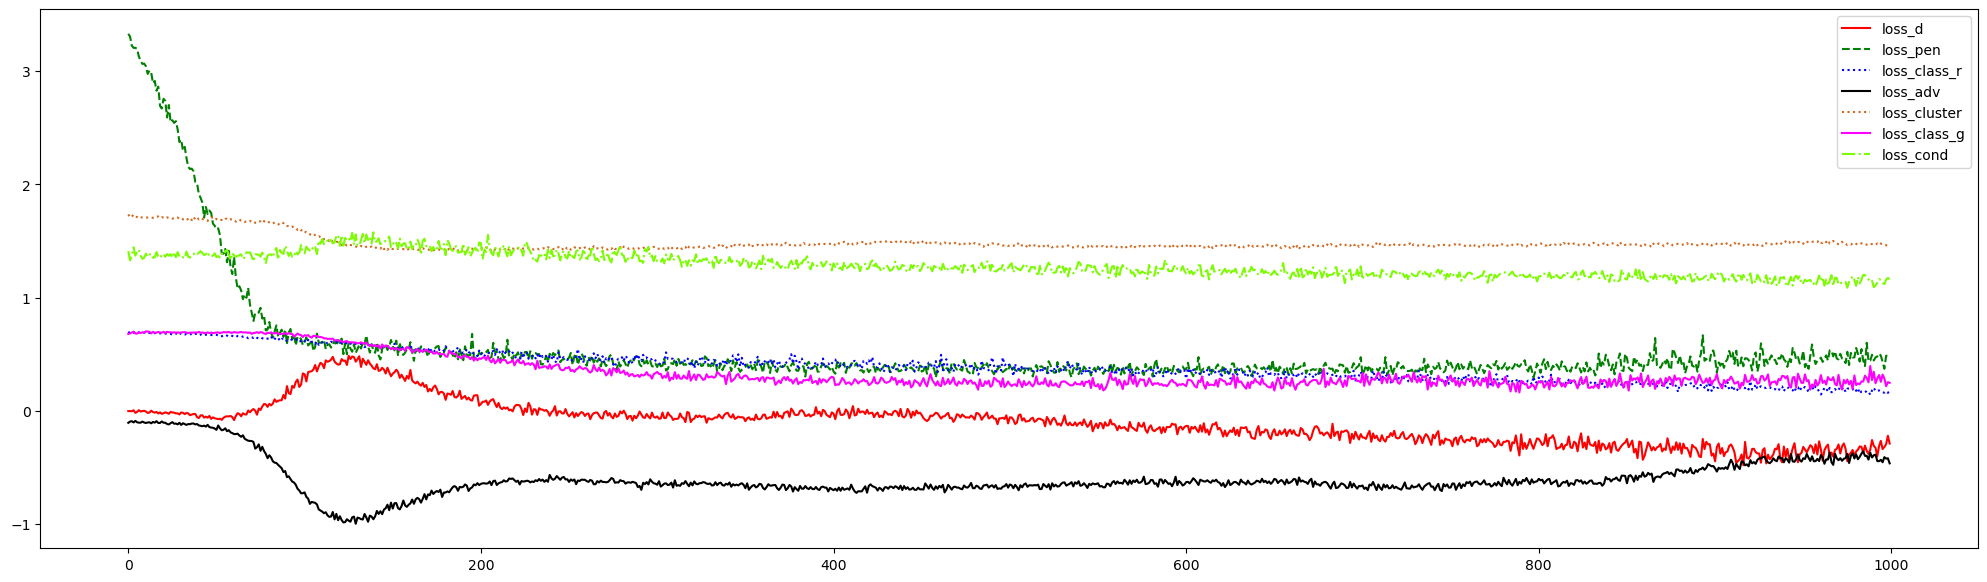

In [7]:
draw_loss(loss)

**存储**

In [9]:
set_seed(42)
minority_dict = {i:class_dis[0][1]-j for i,j in class_dis[1:]}
output_minority = model.synthesis(minority_dict)

for key,value in output_minority.items():
    value['label'] = key

os_trainset = pd.concat([trainset_copy] + list(output_minority.values()),axis=0).sample(frac=1).reset_index(drop=True)
Counter(os_trainset['label']), k

(Counter({0: 605, 1: 605}), 4)

In [9]:
os_trainset.to_csv(f'../Data/train_bala_{k}.csv',index=False,encoding='utf-8')

# 网格调参

In [2]:
from imblearn.over_sampling import ADASYN,SMOTE
from sdv.tabular import CTGAN
from xgboost.sklearn import XGBClassifier
from sdv.sampling import Condition
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [3]:
import os
import random

def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
def evaluate(clf,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
    evaluate_dict = {}
    def GM(y_true,y_pred):
        import numpy as np
        recall = (y_pred[y_true==1]==1).mean()
        tnr = (y_pred[y_true==0]==0).mean()
        return np.sqrt(recall*tnr)
    
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    
    evaluate_dict['AUC'] = roc_auc_score(Y_test,y_proba)
    evaluate_dict['Recall'] = recall_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['F1'] = f1_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['GM'] = GM(Y_test,y_pred)
    
    return evaluate_dict

In [5]:
def train_valid(clf, osmethod, Normlization=True):
    metrics = []
    for k in range(5):
        if osmethod != 'FDGAN':
            data_train = pd.read_csv(f'../Data/train_{k}.csv')
        elif osmethod == 'FDGAN':
            data_train = pd.read_csv(f'../Data/train_bala_{k}.csv')
        
        if osmethod =='ADASYN':
            X_train = data_train.values[:,:-1]
            Y_train = data_train.values[:,-1]
            adasyn = ADASYN(n_jobs=-1,random_state = 42,sampling_strategy=1.0)
            new_Xtrain, new_Ytrain = adasyn.fit_resample(X_train, Y_train)
        elif osmethod =='SMOTE':
            X_train = data_train.values[:,:-1]
            Y_train = data_train.values[:,-1]
            smote = SMOTE(n_jobs=-1,random_state = 42,sampling_strategy=1.0)
            new_Xtrain, new_Ytrain = smote.fit_resample(X_train, Y_train)
        elif osmethod =='CTGAN':
            label_dict = Counter(data_train['label'])
            num_rows = label_dict[0]-label_dict[1]
            learn_df = data_train[data_train['label']==1]
            ctgan = CTGAN()
            ctgan.fit(learn_df)
            condition = Condition({ 'label': 1}, num_rows)
            df = ctgan.sample_conditions(conditions=[condition])
            new_data_train = pd.concat([data_train,df],axis=0)
            new_Xtrain, new_Ytrain = new_data_train.values[:,:-1], new_data_train.values[:,-1]
        elif osmethod == 'FDGAN':
            new_Xtrain,new_Ytrain = data_train.values[:,:-1], data_train.values[:,-1]
        
        index = np.arange(new_Xtrain.shape[0])
        random.seed(42)
        random.shuffle(index)
        new_Xtrain = new_Xtrain[index]
        new_Ytrain = new_Ytrain[index]

        data_valid = pd.read_csv(f'../Data/valid_{k}.csv')
        X_valid, Y_valid = data_valid.values[:,:-1], data_valid.values[:,-1]

        if Normlization:
            new_Xtrain = StandardScaler().fit_transform(new_Xtrain)
            X_valid = StandardScaler().fit_transform(X_valid)

        evaluate_dict = evaluate(clf,new_Xtrain,new_Ytrain,X_valid,Y_valid)
        metrics.append(list(evaluate_dict.values()))
    return metrics

In [6]:
set_seed(seed=42)
best_score = 0
for n_estimators in [200]:
    for max_depth in [7]:
        for learning_rate in [0.04]:
            clf=XGBClassifier(n_estimators=n_estimators,
                              max_depth = max_depth,
                              learning_rate = learning_rate
                              ) 
            metrics = train_valid(clf, osmethod ='FDGAN', Normlization=True)
            data_metrics = pd.DataFrame(metrics,columns=['AUC','Recall','F1','GM'])
            score = data_metrics.AUC.mean()
            if score > best_score:
                best_score = score
                best_parameters={'n_estimators':n_estimators,
                                 'max_depth':max_depth,
                                 'learning_rate':learning_rate}

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:23] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:26] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:27] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
best_parameters

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.04}

# 测试

In [1]:
from imblearn.over_sampling import ADASYN,SMOTE
from sdv.tabular import CTGAN
from sdv.sampling import Condition
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from collections import Counter

import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True

In [3]:
def evaluate(clf,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
    evaluate_dict = {}
    def GM(y_true,y_pred):
        import numpy as np
        recall = (y_pred[y_true==1]==1).mean()
        tnr = (y_pred[y_true==0]==0).mean()
        return np.sqrt(recall*tnr)
    
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    
    #evaluate_dict['Accuracy'] = accuracy_score(Y_test,y_pred)
    evaluate_dict['AUC'] = roc_auc_score(Y_test,y_proba)
    evaluate_dict['Recall'] = recall_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['F1'] = f1_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['GM'] = GM(Y_test,y_pred)
    #evaluate_dict['FPR'] = (y_pred[Y_test==0]==1).mean()
    #evaluate_dict['TNR'] = (y_pred[Y_test==0]==0).mean()
    
    return evaluate_dict

In [4]:
def test(clf,osmethod='FDGAN',Normlization=True):
    if osmethod != 'FDGAN':
        data_rest = pd.read_csv('../Data/rest.csv')
    elif osmethod == 'FDGAN':
        data_rest = pd.read_csv('../Data/rest_bala.csv')
    
    if osmethod =='ADASYN':
        X_train = data_rest.values[:,:-1]
        Y_train = data_rest.values[:,-1]
        adasyn = ADASYN(n_jobs=-1,random_state = 42,sampling_strategy=1.0)
        new_Xtrain, new_Ytrain = adasyn.fit_resample(X_train, Y_train)
    elif osmethod =='SMOTE':
        X_train = data_rest.values[:,:-1]
        Y_train = data_rest.values[:,-1]
        smote = SMOTE(n_jobs=-1,random_state = 42,sampling_strategy=1.0)
        new_Xtrain, new_Ytrain = smote.fit_resample(X_train, Y_train)
    elif osmethod =='CTGAN':
        label_dict = Counter(data_rest['label'])
        num_rows = label_dict[0]-label_dict[1]
        learn_df = data_rest[data_rest['label']==1]
        ctgan = CTGAN()
        ctgan.fit(learn_df)
        condition = Condition({ 'label': 1}, num_rows)
        df = ctgan.sample_conditions(conditions=[condition])
        new_data_rest = pd.concat([data_rest,df],axis=0)
        new_Xtrain, new_Ytrain = new_data_rest.values[:,:-1], new_data_rest.values[:,-1]
    elif osmethod == 'FDGAN':
        new_Xtrain,new_Ytrain = data_rest.values[:,:-1], data_rest.values[:,-1]
    
    index = np.arange(new_Xtrain.shape[0])
    random.seed(42)
    random.shuffle(index)
    new_Xtrain = new_Xtrain[index]
    new_Ytrain = new_Ytrain[index]
    
    data_test = pd.read_csv('../Data/test.csv')
    X_test = data_test.values[:,:-1]
    Y_test = data_test.values[:,-1]
    
    if Normlization:
        new_Xtrain = StandardScaler().fit_transform(new_Xtrain)
        X_test = StandardScaler().fit_transform(X_test)
    
    evaluate_dict = evaluate(clf,new_Xtrain,new_Ytrain,X_test,Y_test)
    return evaluate_dict

In [5]:
set_seed(seed=42)
clf = XGBClassifier(n_estimators=200,max_depth = 7, learning_rate=0.04, random_state=42)

evaluate_dict = test(clf,osmethod='FDGAN',Normlization=False)

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:05:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [6]:
evaluate_dict

{'AUC': 0.8786658999424958,
 'Recall': 0.7446808510638298,
 'F1': 0.7368421052631579,
 'GM': 0.8241781938556382}